# Visualization in TorchOpt

[<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/metaopt/torchopt/blob/main/tutorials/2_Visualization.ipynb)

In [PyTorch](https://pytorch.org), if the attribute `requires_grad` a tensor is `True`, the computation graph will be created if we use the tensor to do any operations. The computation graph is implemented likes link-list -- `Tensor`s are nodes and they are linked by their attribute `gran_fn`. [PyTorchViz](https://github.com/szagoruyko/pytorchviz) is a Python package that uses [Graphviz](https://graphviz.org) as a backend for plotting computation graphs. TorchOpt use PyTorchViz as the blueprint and provide more easy-to-use visualization functions on the premise of supporting all its functions.

Let's start with a simple multiplication computation graph. We declared the variable `x` with flag `requires_grad=True` and compute `y = 2 * x`. Then we visualize the computation graph of `y`.

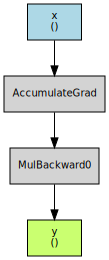

In [1]:
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchopt


x = torch.tensor(1., requires_grad=True)
y = 2 * x
display(torchopt.visual.make_dot(y, params={'x': x, 'y': y}))

The figure shows `y` is connected by the multiplication edge. The gradient of `y` will flow through the multiplication backward function then accumulated on `x`. Note that we pass a dictionary for adding node labels.

Then let's plot a neural network. Note that we can pass the generator returned by method `named_parameters` for adding node labels.

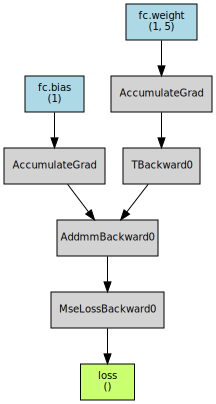

In [2]:
class Net(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1, bias=True)

    def forward(self, x):
        return self.fc(x)


dim = 5
batch_size = 2
net = Net(dim)
xs = torch.ones((batch_size, dim))
ys = torch.ones((batch_size, 1))
pred = net(xs)
loss = F.mse_loss(pred, ys)

display(torchopt.visual.make_dot(loss, params=(net.named_parameters(), {'loss': loss})))

The computation graph of meta learning algorithms will be much more complex. Our visualization tool allows users take as input the extracted network state for better visualization.

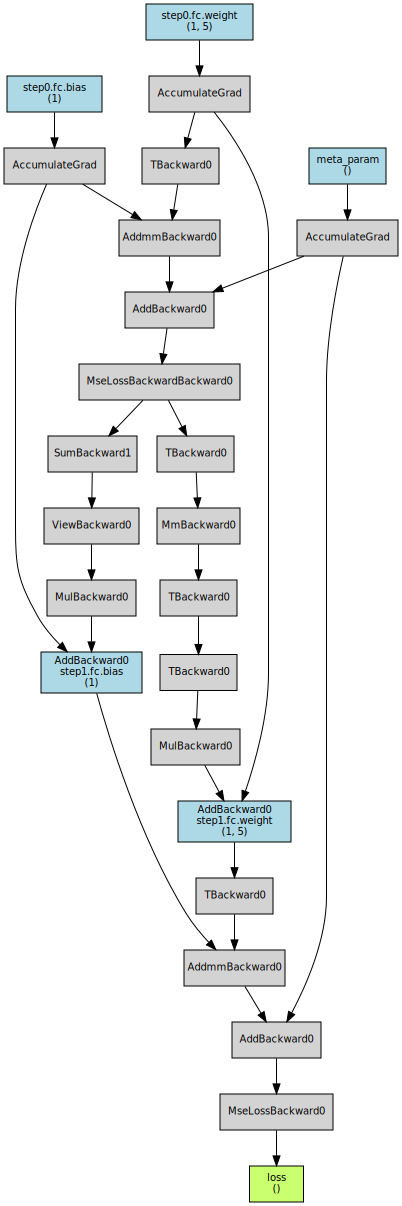

In [3]:
class MetaNet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1, bias=True)

    def forward(self, x, meta_param):
        return self.fc(x) + meta_param


dim = 5
batch_size = 2
net = MetaNet(dim)

xs = torch.ones((batch_size, dim))
ys = torch.ones((batch_size, 1))

optimizer = torchopt.MetaSGD(net, lr=1e-3)
meta_param = torch.tensor(1., requires_grad=True)

# Set enable_visual
net_state_0 = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step0.')

pred = net(xs, meta_param)
loss = F.mse_loss(pred, ys)
optimizer.step(loss)

# Set enable_visual
net_state_1 = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step1.')

pred = net(xs, meta_param)
loss = F.mse_loss(pred, torch.ones_like(pred))

# Draw computation graph
display(torchopt.visual.make_dot(loss, [net_state_0, net_state_1, {'meta_param': meta_param, 'loss': loss}]))